TokaMaker Meshing Example: Building a mesh for DIII-D {#doc_tMaker_DIIID_ex1}
==========
In this example we show how to generate a mesh for the DIII-D device using TokaMaker's built in mesh generation.

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) and [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
# tokamaker_python_path = os.getenv('OFT_ROOTPATH')
# if tokamaker_python_path is not None:
#     sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

In [3]:
plasma_dx = 0.04
coil_dx = 0.03
vv_dx = 0.04
vac_dx = 0.10

In [4]:
with open('../example/DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

In [5]:
# Helper functions

def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

def place_points(npoints, arc, distribution=[]):
    if len(distribution) != npoints+1:
        print('Warning! Distribution length does not match! Overwritting command!')
        distribution = np.ones(npoints+1)

    arclength = np.zeros(np.size(arc[:,0]))
    for i,point in enumerate(arc):
        if i==0:
            arclength[i] = 0
        else:
            arclength[i] = arclength[i-1] + ((arc[i,0]-arc[i-1,0])**2+(arc[i,1]-arc[i-1,1])**2)**0.5
    totlength = arclength[-1]

    tot_dist = np.sum(distribution)
    norm_dist = distribution/tot_dist
    int_dist = np.cumsum(norm_dist)[:-1]

    currind = 0
    inds = []
    locs = []
    for i, point in enumerate(arc):
        if arclength[i]>int_dist[currind]*totlength:
            inds.append(i)
            locs.append(arc[i])
            currind+=1
        if currind == npoints:
            break

    return np.array(inds), np.array(locs)

def update_boundary(r0, z0, a0, kappa, delta, squar, npts=20):
    thp = np.linspace(0,2*np.pi,npts+1)
    thp = thp[:-1]

    ra = r0 + a0*np.cos(thp + delta*np.sin(thp) - squar*np.sin(2*thp))
    za = z0 + kappa*a0*np.sin(thp + squar*np.sin(2*thp))
    return np.vstack([ra, za]).transpose()

def plot_coil(pts, ax, c='k', ls='-', alpha=1):
    ax.plot(np.hstack((pts[:,0],pts[0,0])), np.hstack((pts[:,1],pts[0,1])), c=c, ls=ls, alpha=alpha)

In [6]:
### Define a new coil geometry

# Get the limiter
lim0 = np.array(DIIID_geom['limiter'])
lim = update_boundary(r0=1.69, z0=0, a0=0.67, kappa=2, delta=0.8, squar=0.15, npts=201)

# Make new coils
coil_centers = resize_polygon(lim, 0.2)

def make_new_coils(
        nCoils, 
        distribution, 
        dx = 0.08, 
        dy = 0.08,
        ifplot = True
):

    scan_geom = {}
    scan_geom["coils"] = {}
    
    inds, locs = place_points(nCoils, coil_centers[:len(coil_centers)//2,:], distribution)
    for i, loc in enumerate(locs):
        pts_top = np.array([[loc[0]-dx,loc[1]+dy],[loc[0]+dx,loc[1]+dy],[loc[0]+dx,loc[1]-dy],[loc[0]-dx,loc[1]-dy]])
        pts_bot = pts_top * np.array([1,-1])

        scan_geom["coils"][f'F{i}A'] = {'pts': copy.deepcopy(pts_top), 'nturns':1.0}
        scan_geom["coils"][f'F{i}B'] = {'pts': copy.deepcopy(pts_bot), 'nturns':1.0}

    if ifplot:
        # Make the figure
        plt.figure(figsize = (6,10))
        ax = plt.subplot(111)
        ax.axis('equal')

        # Plot the limiter
        plt.plot(np.hstack((lim0[:,0],lim0[0,0])), np.hstack((lim0[:,1],lim0[0,1])), c='k')
        plt.plot(lim[:,0], lim[:,1], c='k', ls=':')

        # Plot the coils
        for coil in scan_geom["coils"]:
            if 'ECOIL' not in coil:
                pts = np.array(scan_geom["coils"][coil]['pts'])
                plot_coil(pts, ax)
                plt.text(np.average(pts[:,0]), np.average(pts[:,1]), coil, ha='center', va='center')

        # Plot the coils
        plt.plot(coil_centers[:,0], coil_centers[:,1], c='r', ls=':')
        for coil in DIIID_geom["coils"]:
            if 'ECOIL' not in coil:
                pts = np.array(DIIID_geom["coils"][coil]['pts'])
                plot_coil(pts, ax, alpha=0.2, c='r', ls=':')

        ax.set_xlabel('R (m)')
        ax.set_ylabel('Z (m)')

    return scan_geom


In [7]:
def make_mesh(
        DIIID_geom,
        scan_geom,
        savename = 'DIIID_mesh_scantest.h5',
        ifplot = True
):
    # Create a G-S domain
    gs_mesh = gs_Domain()
    # Define region information for mesh
    gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
    gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
    gs_mesh.define_region('vacuum',vv_dx,'vacuum',allow_xpoints=True)  # Define the vacuum inside the VV
    gs_mesh.define_region('vv',vv_dx,'conductor',eta=6e-07)            # Define one region for VV 

    # Define each of the PF coils
    for key, coil in scan_geom["coils"].items():
        if key.startswith('ECOIL'):
            for i, subcoil in enumerate(coil):
                gs_mesh.define_region('{0}_{1}'.format(key,i),coil_dx,'coil',coil_set=key,nTurns=subcoil["nturns"])
        else:
            gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil["nturns"])

    # Define geometry, using the fake limiter
    gs_mesh.add_polygon(lim,'plasma',parent_name='vacuum') 
    gs_mesh.add_annulus(resize_polygon(lim, 0.01),'vacuum',resize_polygon(lim, 0.05),'vv')
    
    gs_mesh.add_enclosed([1.75,1.25],'vacuum')

    # Define each of the PF coils
    for key, coil in scan_geom["coils"].items():
        gs_mesh.add_polygon(coil["pts"],key,parent_name='air')

    # Create mesh
    mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
    coil_dict = gs_mesh.get_coils()
    cond_dict = gs_mesh.get_conductors()

    # Plot result
    if ifplot:
        fig, ax = plt.subplots(2,2,figsize=(8,8),constrained_layout=True)
        gs_mesh.plot_mesh(fig,ax)

    # Save mesh for later use
    save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,savename)

Assembling regions:
  # of unique points    = 856
  # of unique segments  = 47
Generating mesh:
  # of points  = 5369
  # of cells   = 10604
  # of regions = 14
Assembling regions:
  # of unique points    = 856
  # of unique segments  = 47
Generating mesh:
  # of points  = 5354
  # of cells   = 10574
  # of regions = 14
Assembling regions:
  # of unique points    = 854
  # of unique segments  = 47
Generating mesh:
  # of points  = 5239
  # of cells   = 10346
  # of regions = 14
Assembling regions:
  # of unique points    = 854
  # of unique segments  = 47
Generating mesh:
  # of points  = 5301
  # of cells   = 10470
  # of regions = 14
Assembling regions:
  # of unique points    = 850
  # of unique segments  = 47
Generating mesh:
  # of points  = 5239
  # of cells   = 10350
  # of regions = 14
Assembling regions:
  # of unique points    = 854
  # of unique segments  = 47
Generating mesh:
  # of points  = 5309
  # of cells   = 10486
  # of regions = 14
Assembling regions:
  # of unique 

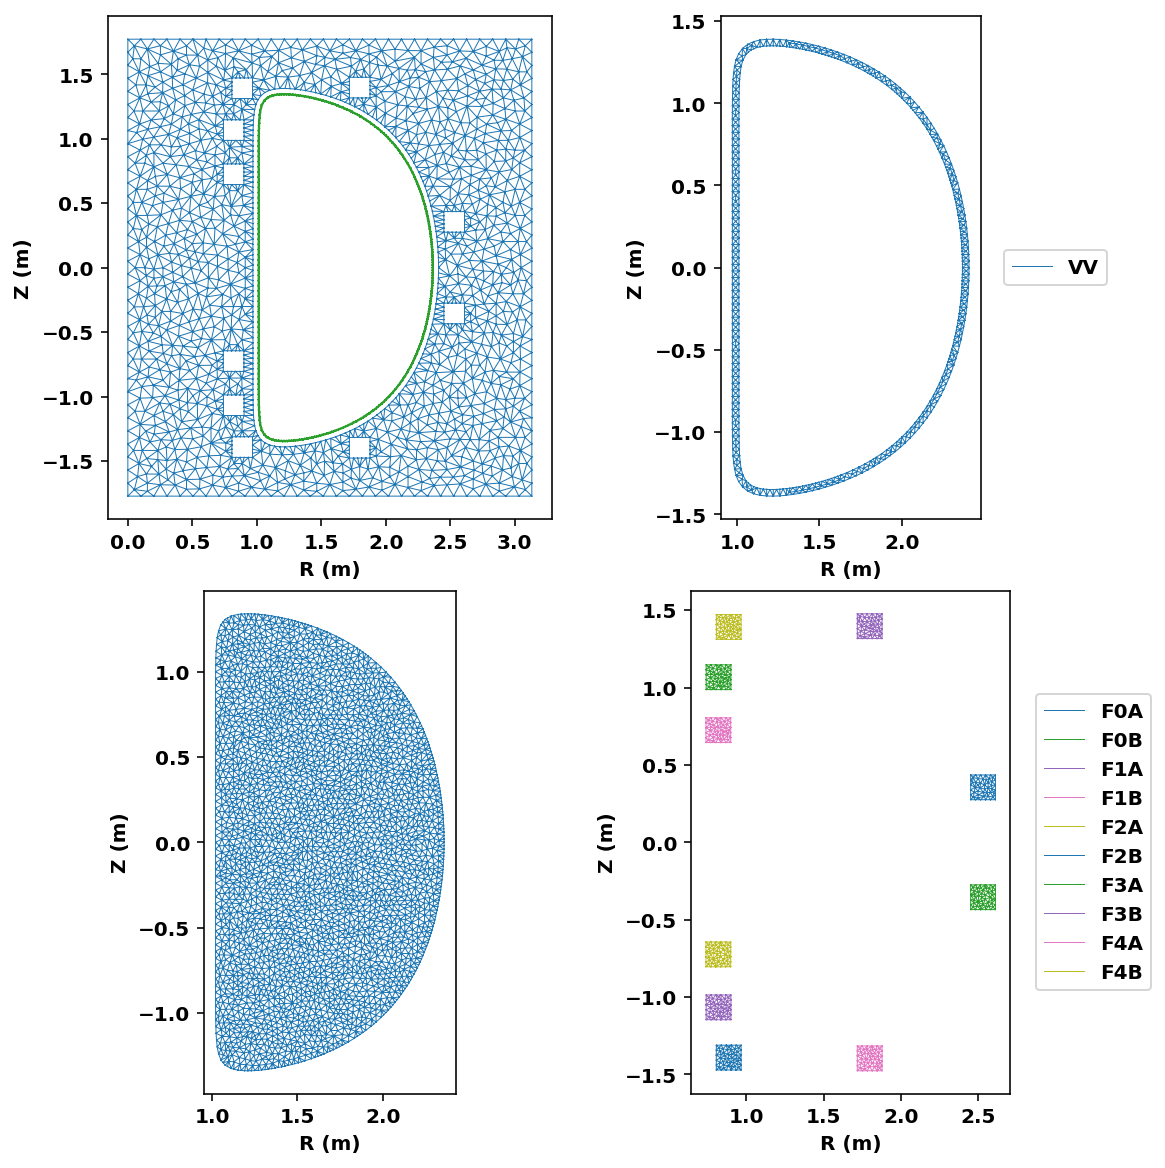

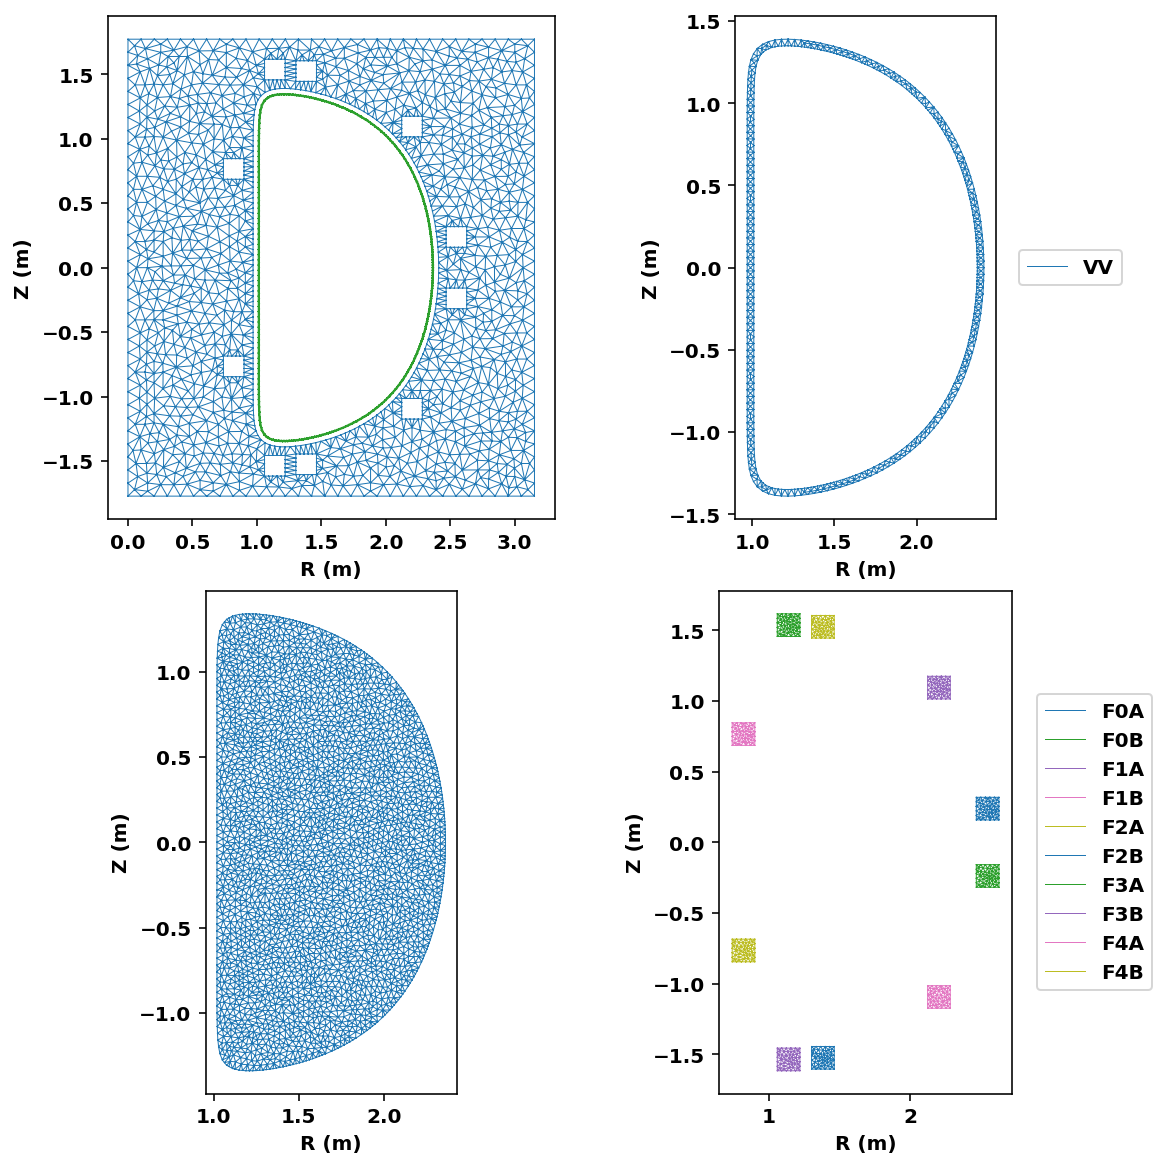

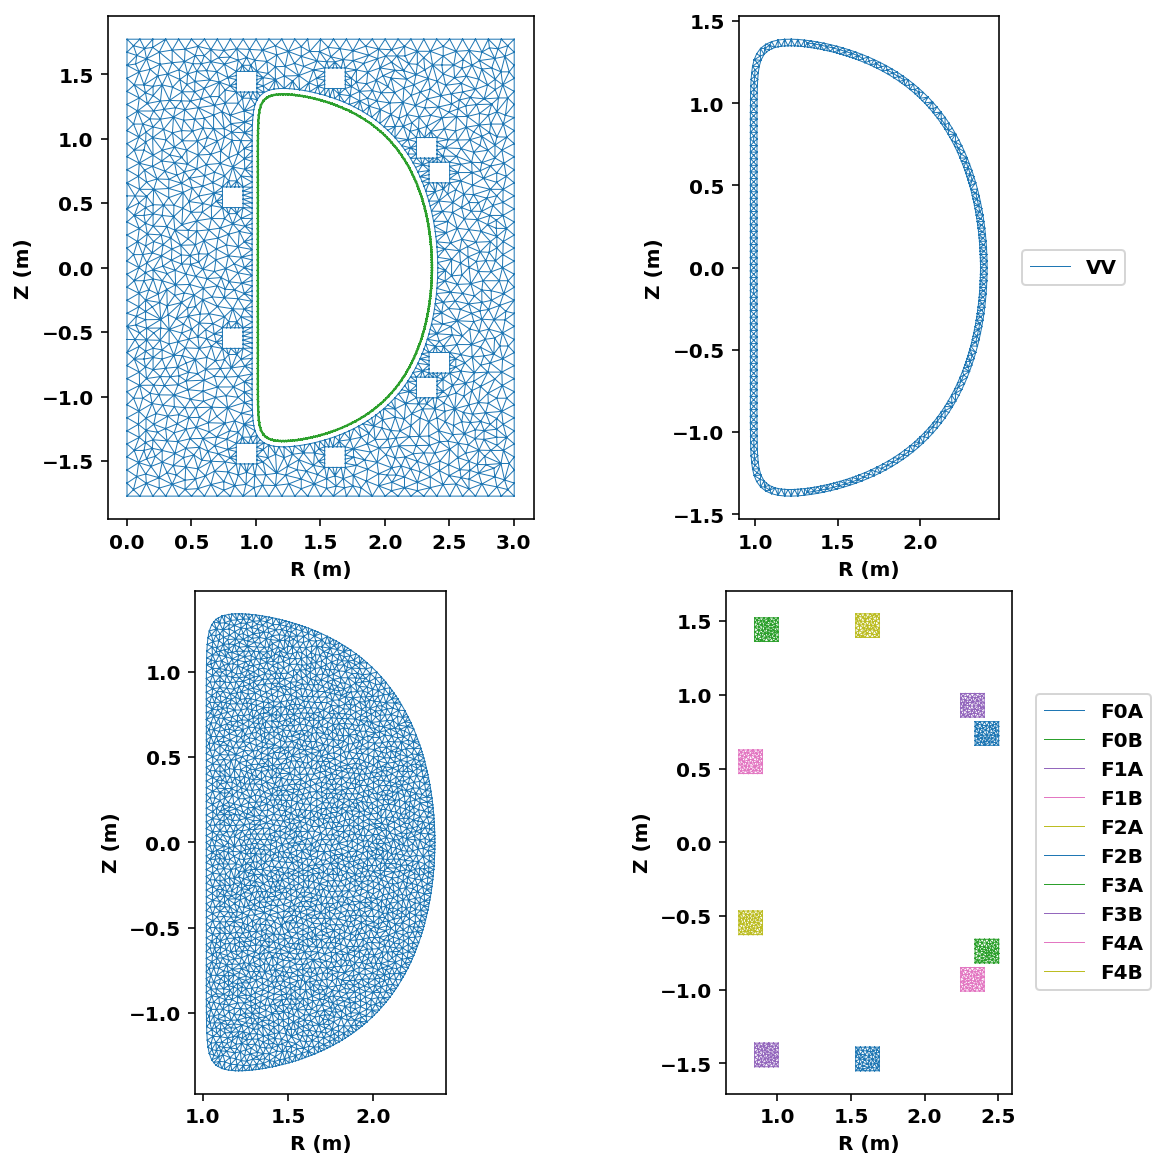

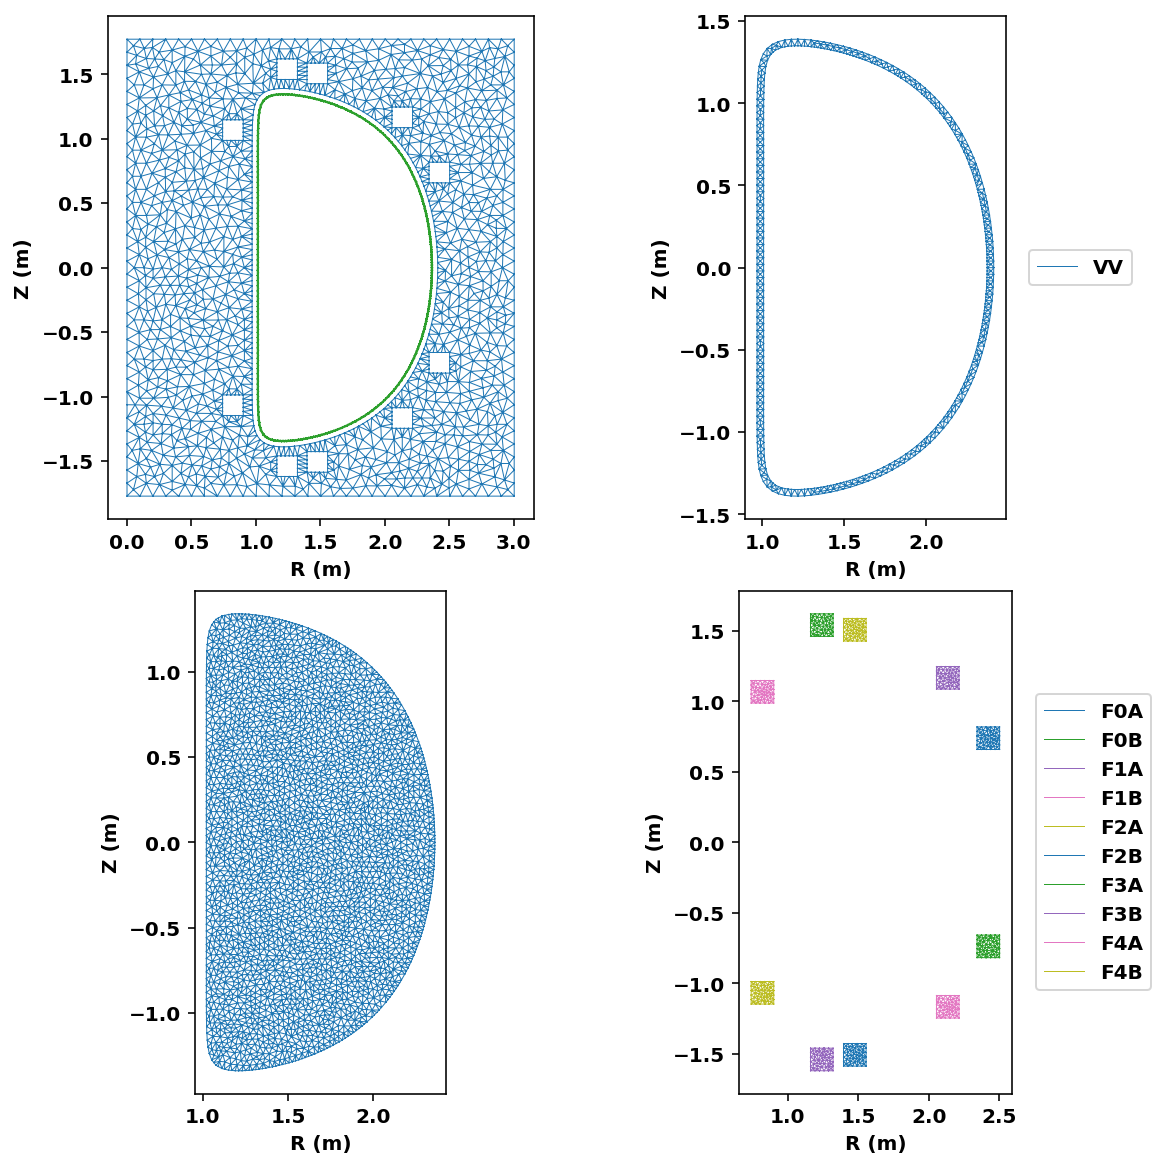

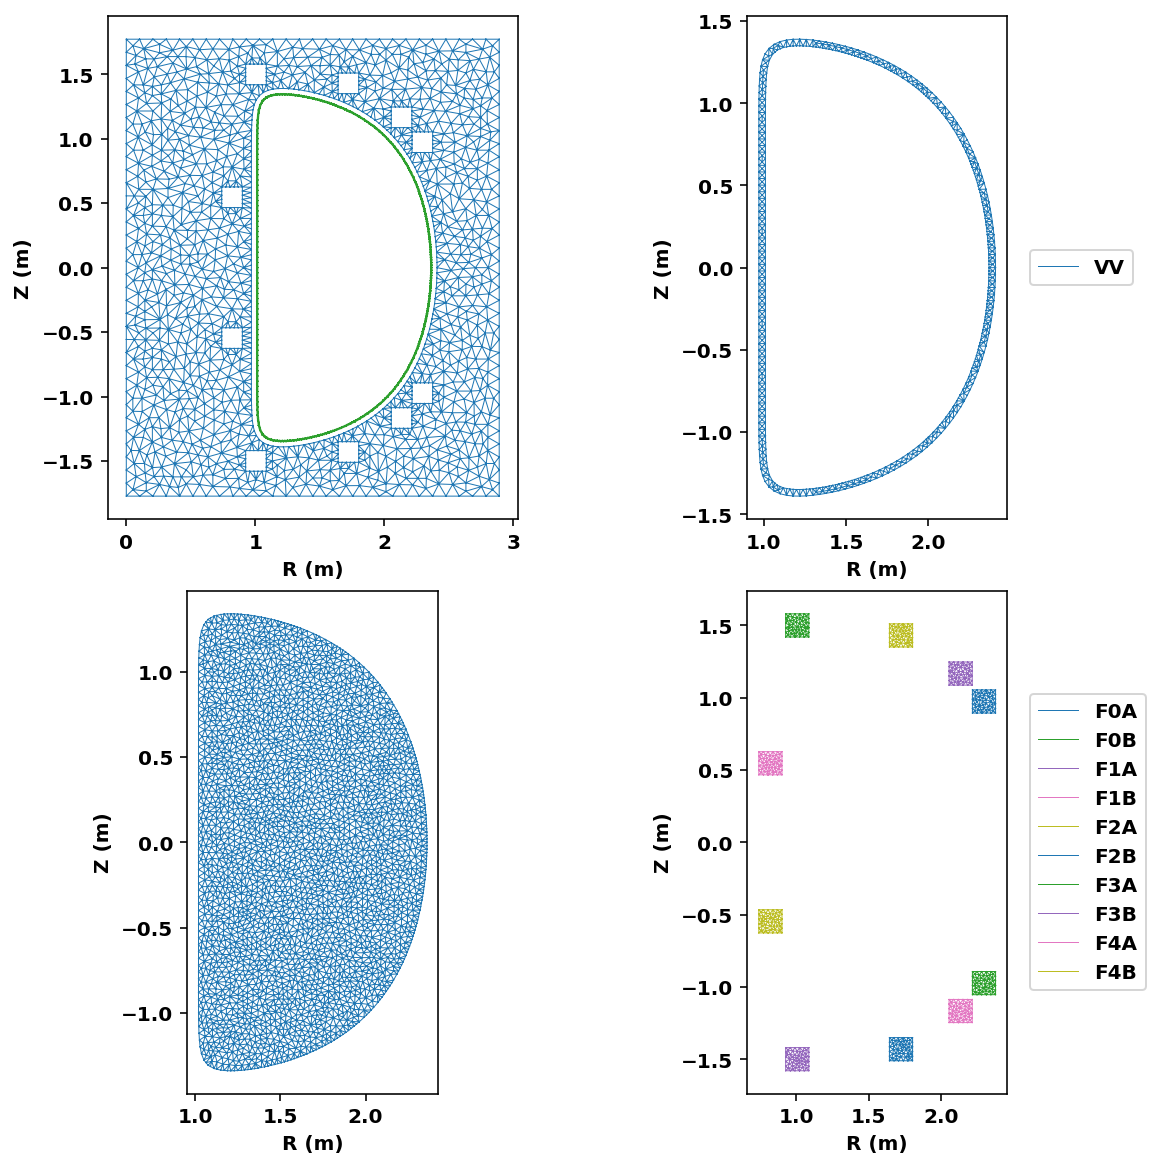

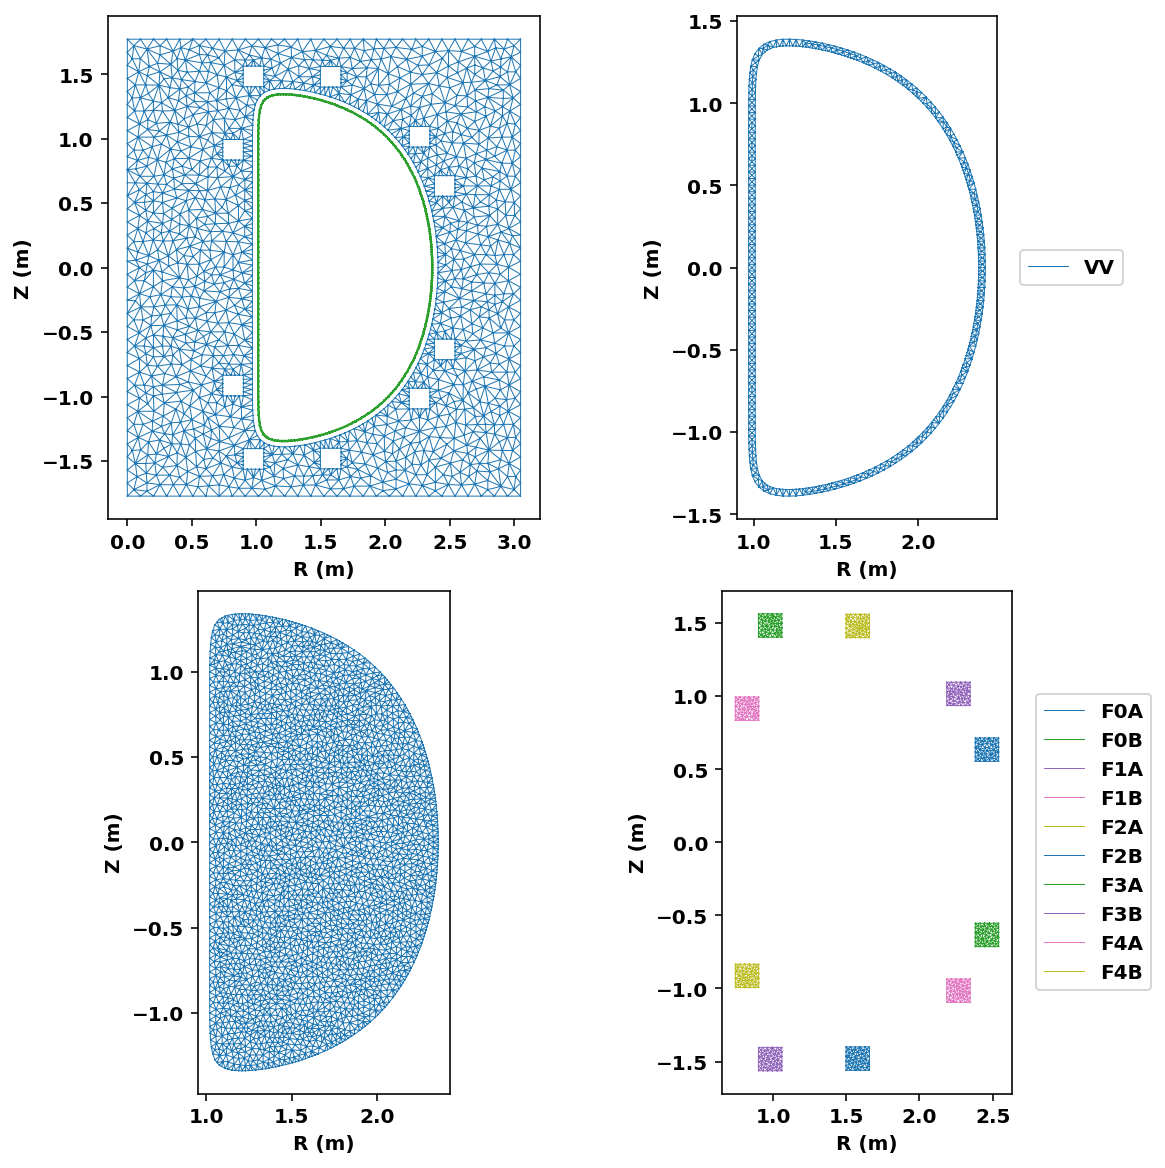

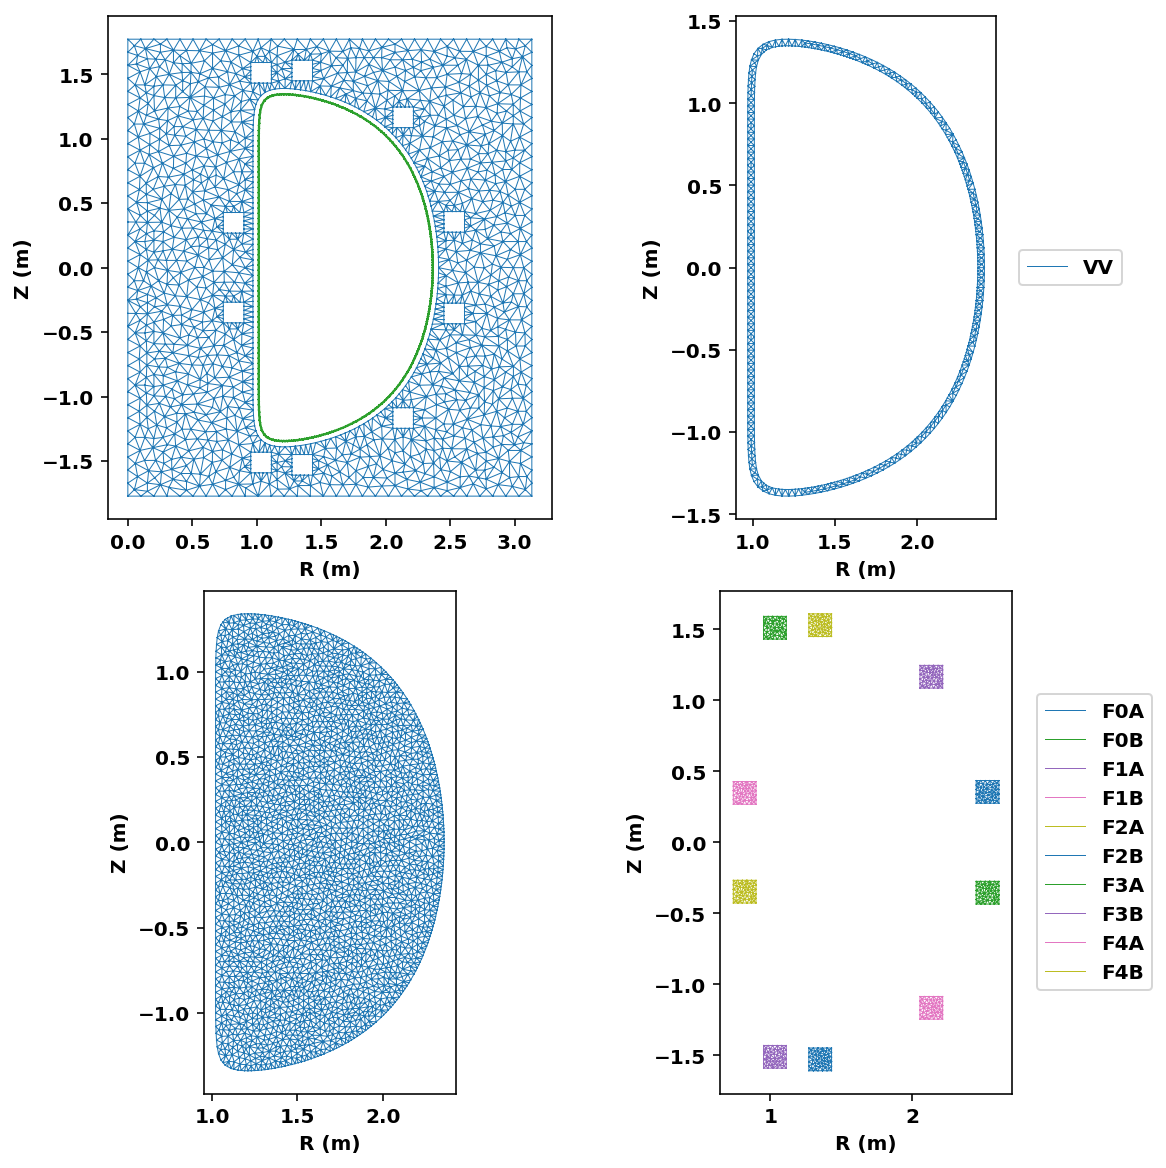

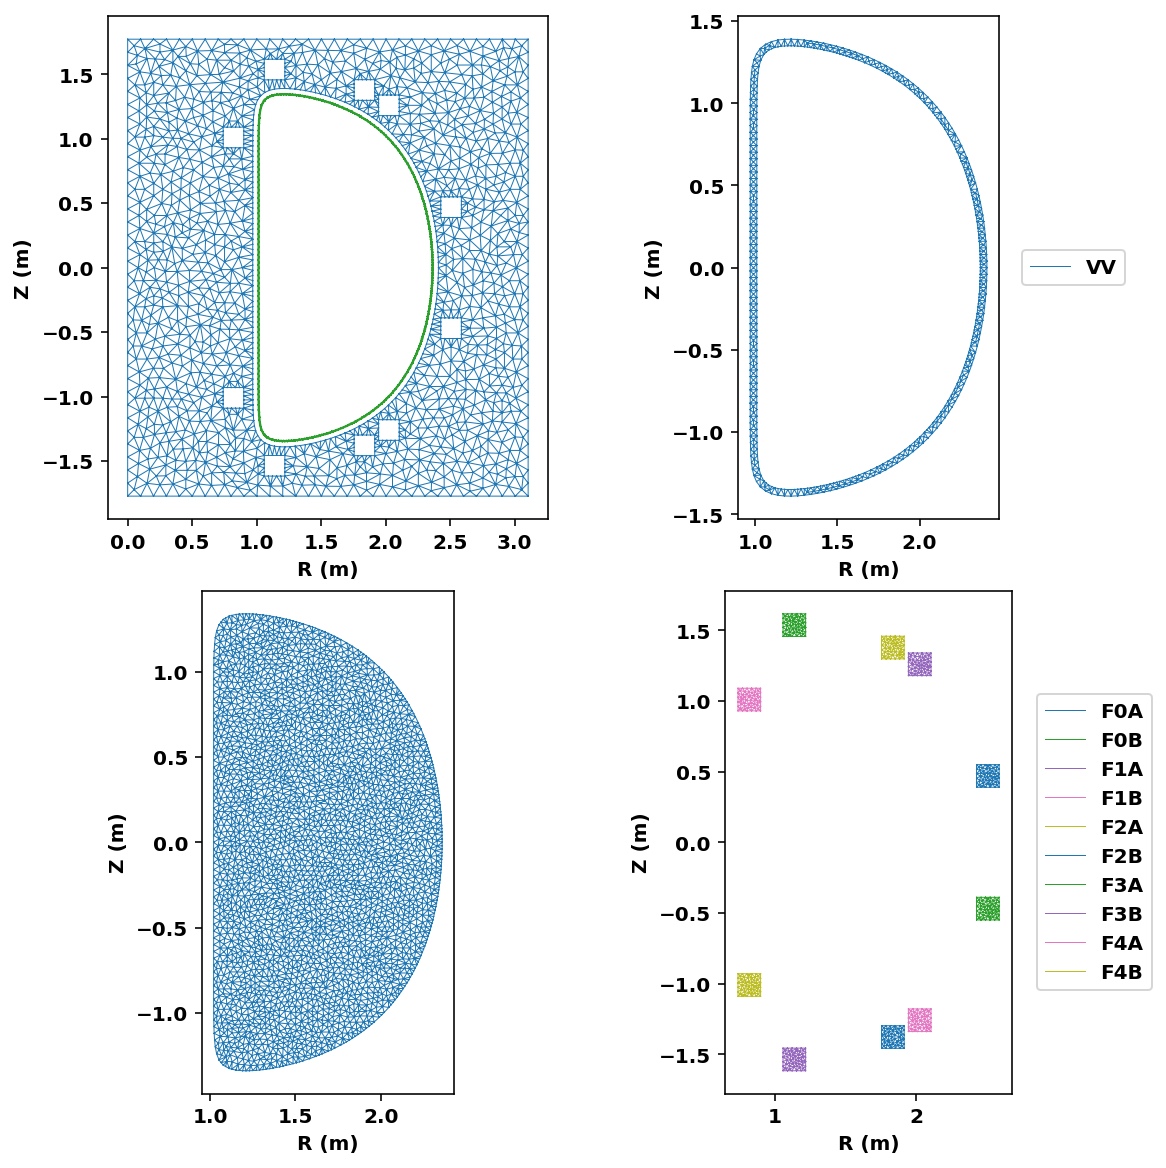

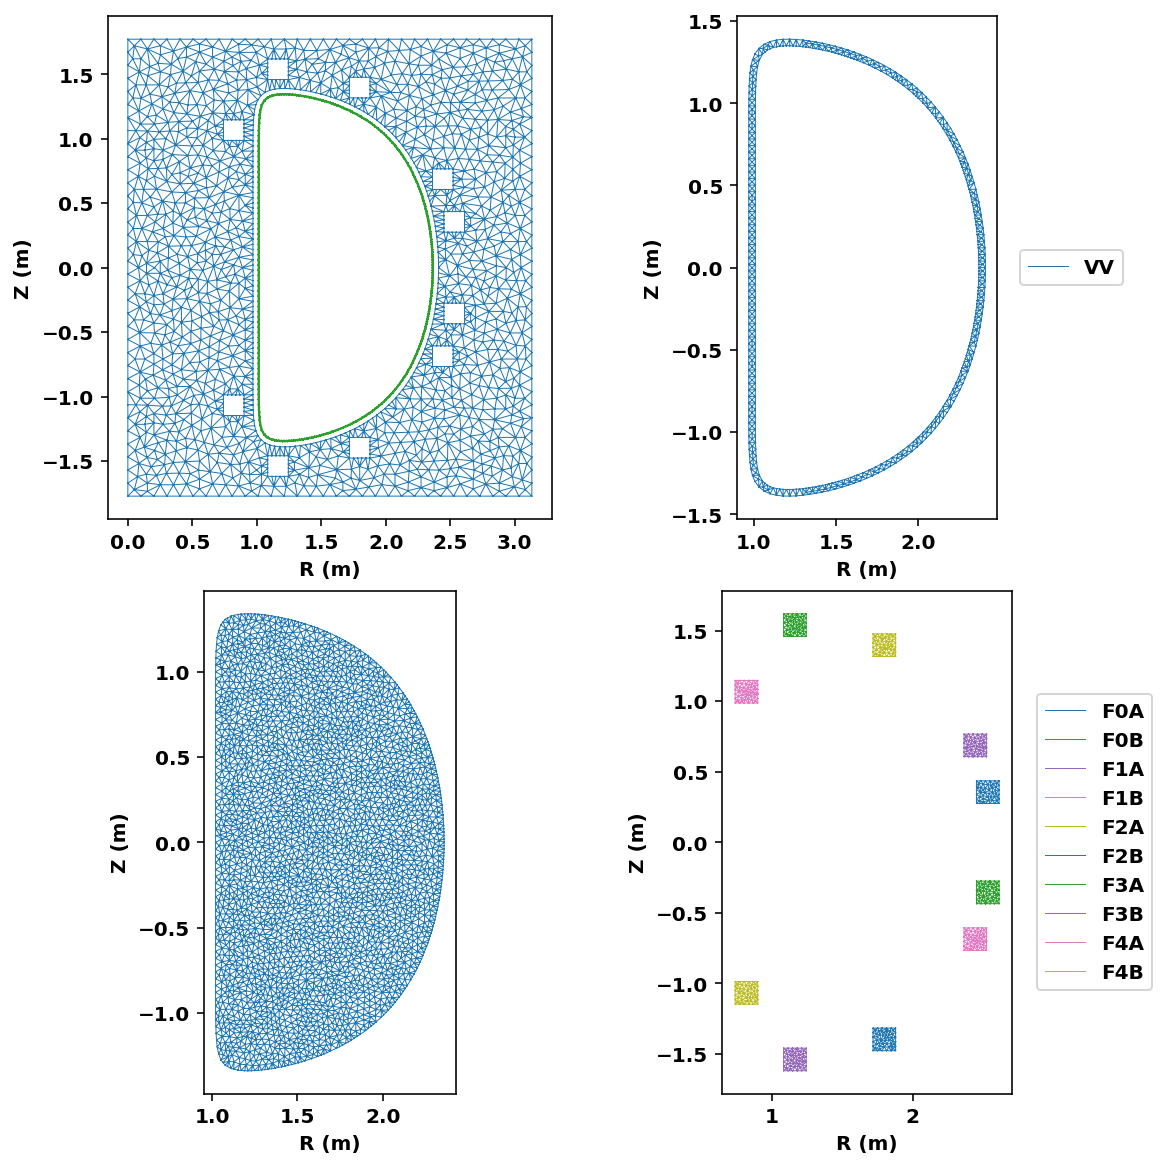

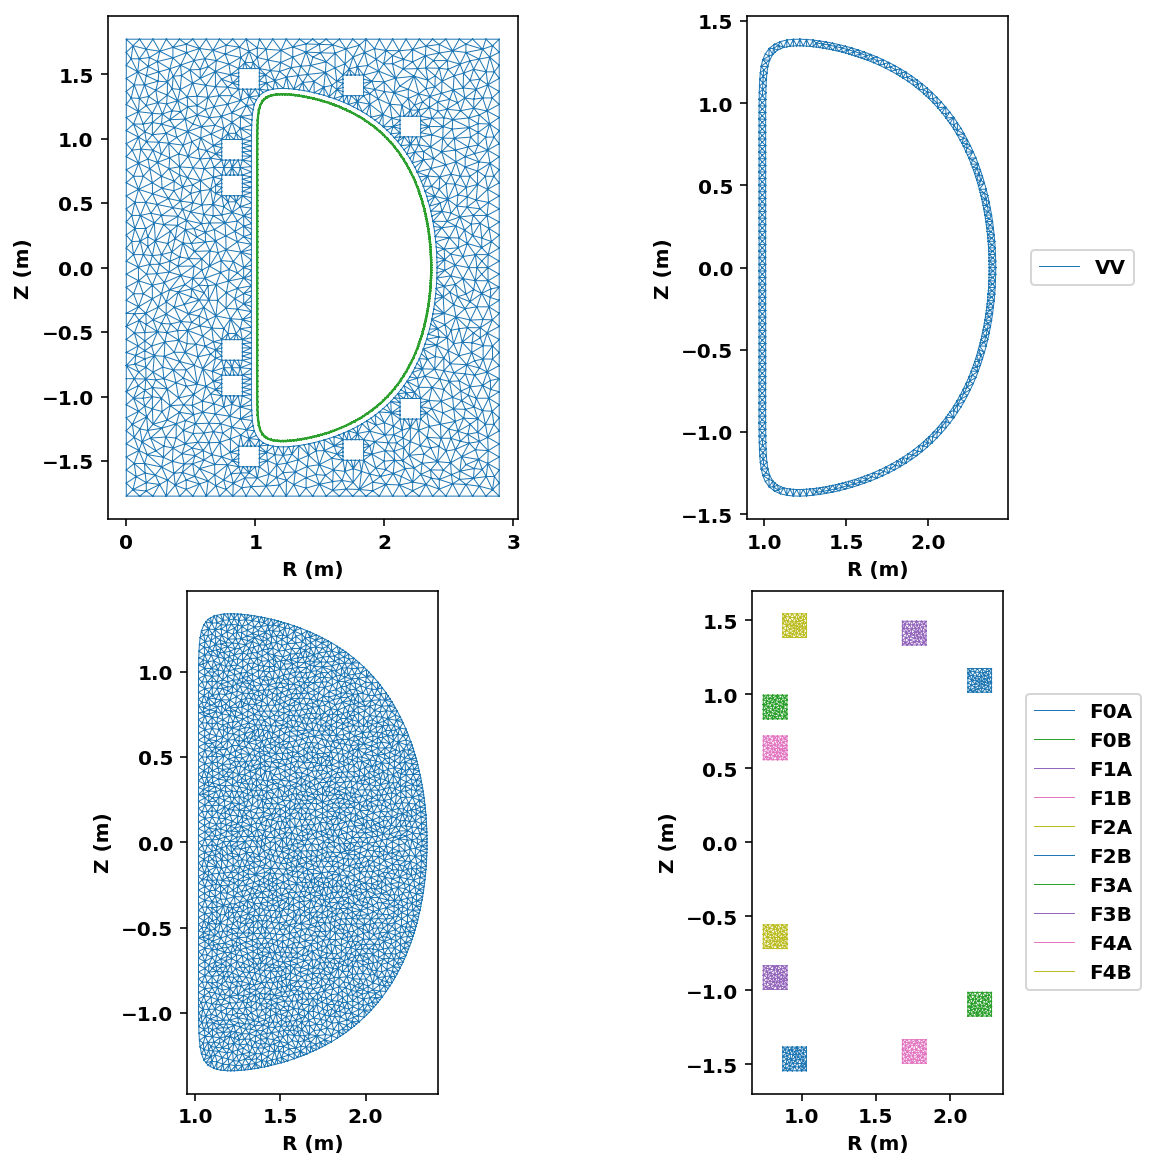

In [8]:
nCoils = 5 # top only, symmetric
nTrials = 10 # number of trials to run

# Make a bunch of meshes 
for i in np.arange(nTrials):
    distribution = np.random.randint(low=1,high=5,size=nCoils+1)
    savedist = '-'.join([str(x) for x in distribution])
    savename = f'mesh_n{nCoils}_d{savedist}.h5'

    if savename not in os.listdir('.'):
        scan_geom = make_new_coils(nCoils, distribution, ifplot=False)

        make_mesh(DIIID_geom, scan_geom, savename=savename, ifplot=True)